In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
tcs_data_new= pd.read_csv('TCS_DATA.csv')

In [3]:
tcs_data_new.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change(%)'], dtype='object')

In [4]:
tcs_data_new.head()

,Date,Price,Open,High,Low,Volume,Change(%)
0,23-Aug-23,3398.25,3388.0,3402.00,3376.00,1330046,0.48%
1,22-Aug-23,3382.15,3400.0,3411.00,3365.05,1222012,-0.57%
2,21-Aug-23,3401.65,3375.0,3409.75,3372.00,1375579,1.03%
3,18-Aug-23,3367.10,3410.0,3410.00,3356.50,2526749,-2.00%
4,17-Aug-23,3435.75,3455.0,3460.80,3413.20,1843241,-0.65%


In [5]:
tcs_data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4713 entries, 0 to 4712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4713 non-null   object 
 1   Price      4713 non-null   float64
 2   Open       4713 non-null   float64
 3   High       4713 non-null   float64
 4   Low        4713 non-null   float64
 5   Volume     4713 non-null   int64  
 6   Change(%)  4713 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 257.9+ KB


# Data Cleaning

In [6]:

tcs_data_new['Date'] = pd.to_datetime(tcs_data_new['Date'])

#Sorting the date column in ascending order
tcs_data_new.sort_values(by='Date', inplace=True)
tcs_data_new.set_index('Date', inplace=True)


#Filter the data between the start and end dates
start_date = '2015-01-01'
end_date = '2023-08-30'
tcs_data_new = tcs_data_new.loc[start_date:end_date]
tcs_data_new.head()

,Price,Open,High,Low,Volume,Change(%)
Date,,,,,,
2015-01-01,1272.78,1283.50,1283.50,1270.50,183415,-0.50%
2015-01-02,1289.73,1275.50,1295.48,1275.30,462870,1.33%
2015-01-05,1270.13,1290.50,1299.95,1262.33,877121,-1.52%
2015-01-06,1223.30,1264.55,1264.55,1220.00,1211892,-3.69%
2015-01-07,1208.85,1235.00,1239.58,1203.73,1318166,-1.18%


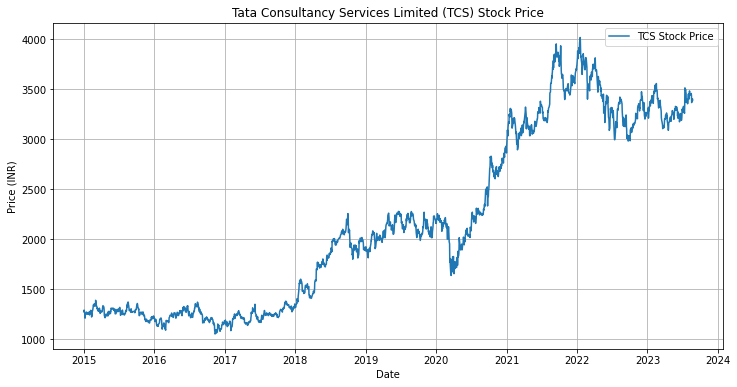

In [7]:
#stock price graph
plt.figure(figsize=(12, 6))
plt.plot(tcs_data_new['Price'], label='TCS Stock Price')
plt.title('Tata Consultancy Services Limited (TCS) Stock Price')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

# Forecasting

A time series is composed of 4 parts:
    
1. The average value in the series is called the level.
2. The increasing or falling value in the series is referred to as the trend.
3. Seasonality is the series’ recurring short-term cycle.
4. The random variance in the series is referred to as noise.


## Step 1: Stationarity

_The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance)_

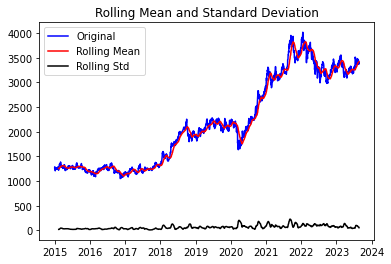

In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

test_stationarity(tcs_data_new['Price'])

### ADF Testing to check for stationarity

In [9]:
#Augmented dickey fuller test
#Performing the ADF test on the stock price series
result = adfuller(tcs_data_new['Price'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
if result[1]<0.05:
    print(f'The progression of TCS stock is STATIONARY')
else:
    print(f'The progression of TCS stock is NON-STATIONARY')
    

ADF Statistic: -0.6413841152308938
n_lags: 0.8613540978725478
p-value: 0.8613540978725478
The progression of TCS stock is NON-STATIONARY


### Applying Differencing

Identified: 
1. Increasing Trend
2. Yearly Seasonality 

So differencing needs to be applied 2 times

Separating the Time Series into it's 4 components

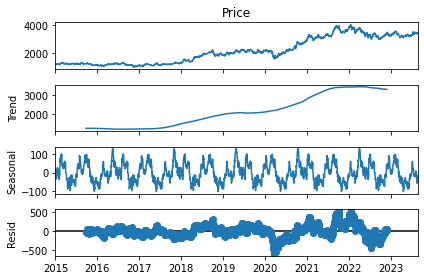

In [10]:
tcs_decomposition_new = seasonal_decompose(tcs_data_new['Price'], period=365)
# Plotting the decomposed components
tcs_decomposition_new.plot()
plt.show()

In [11]:
#Applying first-order differencing to the stock price series
tcs_data_differenced = tcs_data_new['Price'].diff().dropna()
#Applying second differencing to the stock price series to account for seasonality
tcs_data_differenced_second = tcs_data_differenced.diff(365).dropna()

#Performing the ADF test on the differenced series
adf_result_differenced = adfuller(tcs_data_differenced_second)


#Extracting the test statistic and p-value for the differenced series
adf_statistic_differenced = adf_result_differenced[0]
adf_pvalue_differenced = adf_result_differenced[1]

if adf_pvalue_differenced<0.05:
    print(f'The progression of TCS stock after differencing is STATIONARY')
else:
    print(f'The progression of TCS stock after differencing is NON-STATIONARY')

The progression of TCS stock after differencing is STATIONARY


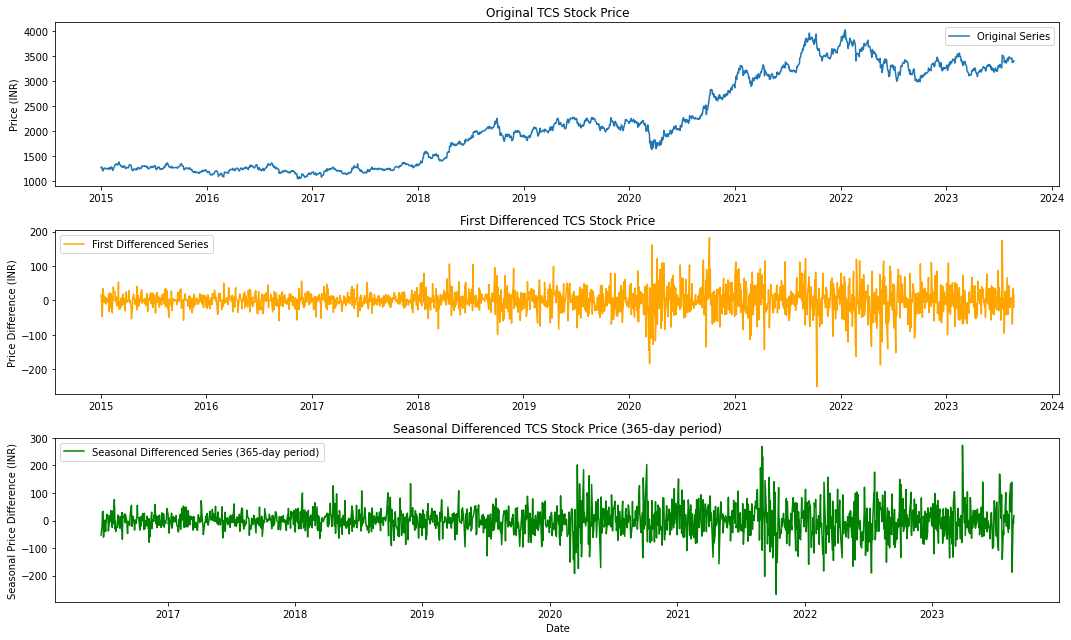

In [12]:
#Plotting the original series, first differenced series, and seasonal differenced series
plt.figure(figsize=(15, 9))

plt.subplot(3, 1, 1)
plt.plot(tcs_data_new['Price'], label='Original Series')
plt.title('Original TCS Stock Price')
plt.ylabel('Price (INR)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(tcs_data_differenced, label='First Differenced Series', color='orange')
plt.title('First Differenced TCS Stock Price')
plt.ylabel('Price Difference (INR)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tcs_data_differenced_second, label='Seasonal Differenced Series (365-day period)', color='green')
plt.title('Seasonal Differenced TCS Stock Price (365-day period)')
plt.xlabel('Date')
plt.ylabel('Seasonal Price Difference (INR)')
plt.legend()

plt.tight_layout()
plt.show()

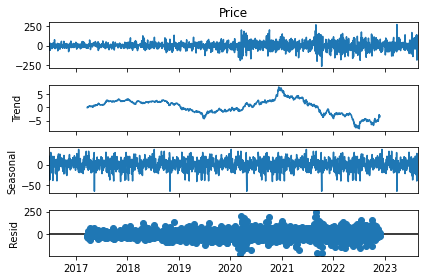

In [13]:
tcs_decomposition_new = seasonal_decompose(tcs_data_differenced_second, period=365)
# Plotting the decomposed components
tcs_decomposition_new.plot()
plt.show()

**The Ideal Value for Q (order of differencing) is 2**

-------------------------------------------------------

## Step 2: Finding order of Autoregressive Function

The AR coefficient tells us the correlation between our current state and the lagged state (k). The PACF plot tells us the direct correlation between an observation and its lagged value (k) after removing the effect of any correlations due to the terms at shorter lags, and it helps in identifying the order of the AR part of an ARIMA model.

 The PACF plot is particularly useful for identifying the order of the AR part of an ARIMA model. A significant spike at lag kk in the PACF plot suggests that the AR order should be at least kk

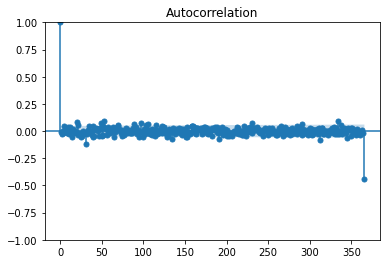

In [14]:
plot_acf(tcs_data_differenced_second, lags=365)
pyplot.show()

Partial Autocorrelation drops to negligible values after 1, so 1 is an ideal value for P

## Step 3: Finding Order of Moving Average Function (Q)
    
The MA coefficient tells us the relationship between the current observation and the residual errors from previous time steps, describing how the current value is influenced by past forecast errors. The ACF plot shows the correlation between an observation and its lagged values, including both direct and indirect effects, and helps in identifying the order of the MA part of an ARIMA model.

A gradual decrease in the ACF values might suggest a MA process, and the lag at which the ACF cuts off is often used as an indication of the MA order

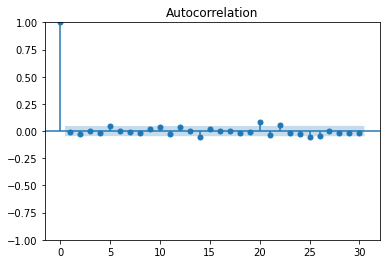

In [15]:
plot_acf(tcs_data_differenced_second, lags=30)
pyplot.show()

Autocorrelation drops to zero after 1, so 1 is an ideal value for Q

**ARIMA Parameters: P,D,Q (1,2,1)**

## Step 4: Creating an ARIMA model

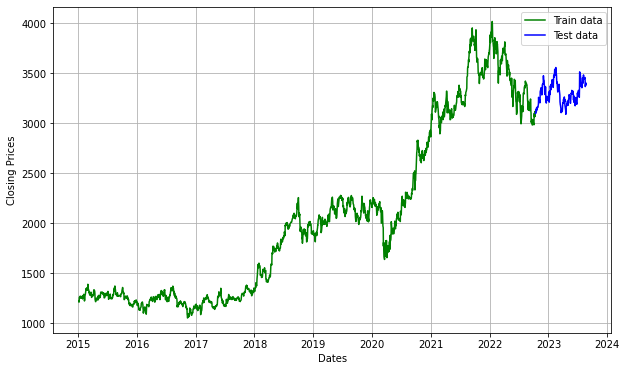

In [16]:
#split data into train and training set
train_data, test_data = tcs_data_new['Price'][3:int(len(tcs_data_new['Price'])*0.90)], tcs_data_new['Price'][int(len(tcs_data_new['Price'])*0.90):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

D:\pythonProject\general_python_codes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\pythonProject\general_python_codes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\pythonProject\general_python_codes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\pythonProject\general_python_codes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

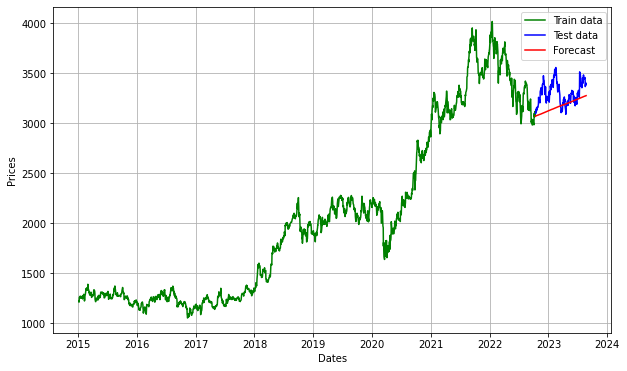

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1923
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -9498.719
Date:                Fri, 25 Aug 2023   AIC                          19003.438
Time:                        09:11:53   BIC                          19020.120
Sample:                             0   HQIC                         19009.576
                               - 1923                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0089      0.017     -0.528      0.598      -0.042       0.024
ma.L1         -0.9998      0.006   -177.229      0.000      -1.011      -0.989
sigma2      1150.2445     21.981     52.328      0.0

In [17]:
#Define the ARIMA model with orders (p=1, d=0, q=1)
model = ARIMA(train_data, order=(1, 2, 1))

#Fit the model
fit_model = model.fit()

#Forecasting on the test data
forecast_values_test = fit_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

#Plotting the training data, test data, and forecast
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data.index, test_data, 'blue', label='Test data')
plt.plot(test_data.index, forecast_values_test, 'red', label='Forecast')
plt.legend()
plt.show()

# Summary of the model
print(fit_model.summary())


D:\pythonProject\general_python_codes\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


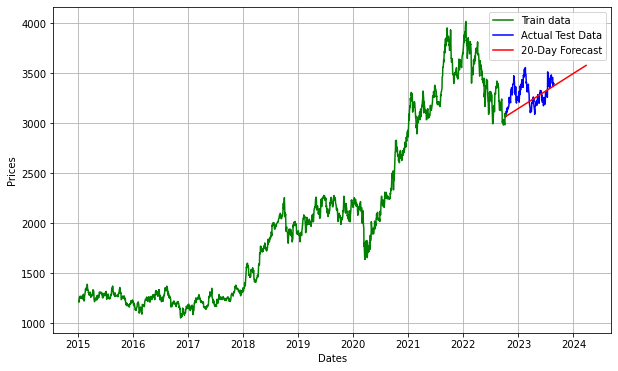

In [18]:
# Forecasting the next 530 observations (2 years)
forecast_values = fit_model.predict(start=len(train_data), end=len(train_data)+530)
forecast_index = pd.date_range(train_data.index[-1], periods=532, freq='D')[1:]
forecast_series = pd.Series(forecast_values.values, index=forecast_index)


plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data[:365], 'blue', label='Actual Test Data')
plt.plot(forecast_series, 'red', label='20-Day Forecast')
plt.legend()
plt.show()

In [19]:

# report performance
mse = mean_squared_error(test_data, forecast_values_test.values)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast_values_test.values)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast_values_test.values))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values_test.values - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 30105.56972946502
MAE: 140.25177038343435
RMSE: 173.50956667995288
MAPE: 0.041666609929680715


## A MAPE of 4.16% suggests that the model's forecasts are generally close to the actual values, with an average percentage error of around 4.16%

## The trend is captured but the exact value is not. The long term trend is captured, but this model will not suffice for short term fluctuations